In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:36231")
client

<Client: 'tcp://127.0.0.1:36231' processes=8 threads=64, memory=235.96 GiB>

In [2]:
client.restart()

<Client: 'tcp://127.0.0.1:34803' processes=0 threads=0, memory=0 B>

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
from fastjmd95 import rho
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import os
import gcsfs

SCRATCH = os.environ['SCRATCH_BUCKET']
SCRATCH

'gcs://meom-ige-scratch/roxyboy'

In [4]:
from xmitgcm import llcreader
model = llcreader.ECCOPortalLLC4320Model()
print(model.varnames)

['Eta', 'KPPhbl', 'oceFWflx', 'oceQnet', 'oceQsw', 'oceSflux', 'oceTAUX', 'oceTAUY', 'PhiBot', 'Salt', 'SIarea', 'SIheff', 'SIhsalt', 'SIhsnow', 'SIuice', 'SIvice', 'Theta', 'U', 'V', 'W']


In [5]:
months = {'aug':['2011-08-01','2011-08-31'],
          'sep':['2011-09-01','2011-09-30'],
          'oct':['2011-10-01','2011-10-31'],
          'feb':['2012-02-01','2012-02-29'],
          'mar':['2012-03-01','2012-03-31'],
          'apr':['2012-04-01','2012-04-30']}
list(months.keys())

['aug', 'sep', 'oct', 'feb', 'mar', 'apr']

# Region 01

<xarray.DataArray 'time' (time: 24)>
array(['2012-04-29T00:00:00.000000000', '2012-04-29T01:00:00.000000000',
       '2012-04-29T02:00:00.000000000', '2012-04-29T03:00:00.000000000',
       '2012-04-29T04:00:00.000000000', '2012-04-29T05:00:00.000000000',
       '2012-04-29T06:00:00.000000000', '2012-04-29T07:00:00.000000000',
       '2012-04-29T08:00:00.000000000', '2012-04-29T09:00:00.000000000',
       '2012-04-29T10:00:00.000000000', '2012-04-29T11:00:00.000000000',
       '2012-04-29T12:00:00.000000000', '2012-04-29T13:00:00.000000000',
       '2012-04-29T14:00:00.000000000', '2012-04-29T15:00:00.000000000',
       '2012-04-29T16:00:00.000000000', '2012-04-29T17:00:00.000000000',
       '2012-04-29T18:00:00.000000000', '2012-04-29T19:00:00.000000000',
       '2012-04-29T20:00:00.000000000', '2012-04-29T21:00:00.000000000',
       '2012-04-29T22:00:00.000000000', '2012-04-29T23:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2012-04-

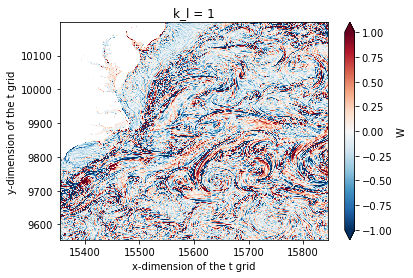

<xarray.Dataset>
Dimensions:  (i: 491, j: 644, k_l: 52)
Coordinates:
  * i        (i) int64 15355 15356 15357 15358 15359 ... 15842 15843 15844 15845
  * j        (j) int64 9555 9556 9557 9558 9559 ... 10195 10196 10197 10198
  * k_l      (k_l) int64 0 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50 51
Data variables:
    W        (k_l, j, i) float32 dask.array<chunksize=(10, 100, 100), meta=np.ndarray>
gcs://meom-ige-scratch/roxyboy/region01/LLC4320/apr/W_29.zarr
<xarray.DataArray 'time' (time: 24)>
array(['2012-04-30T00:00:00.000000000', '2012-04-30T01:00:00.000000000',
       '2012-04-30T02:00:00.000000000', '2012-04-30T03:00:00.000000000',
       '2012-04-30T04:00:00.000000000', '2012-04-30T05:00:00.000000000',
       '2012-04-30T06:00:00.000000000', '2012-04-30T07:00:00.000000000',
       '2012-04-30T08:00:00.000000000', '2012-04-30T09:00:00.000000000',
       '2012-04-30T10:00:00.000000000', '2012-04-30T11:00:00.000000000',
       '2012-04-30T12:00:00.000000000', '2012-04-30T13:

In [7]:
mstart = 5
dstart = 28

istart = 497664
di = 144
# iters = np.arange(istart,int(istart+(29+31+30)*24*di),di)

for month in list(months.keys())[mstart:]:
    
    dates = pd.date_range(months[month][0],months[month][1],freq='D')
    
    if month == list(months.keys())[mstart]:
        ddstart = dstart
    else:
        ddstart = 0
        
    for dd in range(ddstart,len(dates)):
        
        if month == 'feb':
            iters = np.arange(istart+di*dd*24,
                              istart+di*dd*24+di*24,di)
        elif month == 'mar':
            iters = np.arange(istart+di*dd*24+29*24*di,
                              istart+di*dd*24+di*24+29*24*di,di)
        else:
            iters = np.arange(istart+di*dd*24+(29+31)*24*di,
                              istart+di*dd*24+di*24+(29+31)*24*di,di)
        
        for kk in range(52):
            dsw01 = model.get_dataset(varnames=['W'], k_levels=[kk], 
                                      iters=list(iters),
                                      type='latlon').sel(
#                                                          time=slice(str(dates[dd])[:11]+"00:00",
#                                                                     str(dates[dd])[:11]+"23:59"),
                                                         j=slice(9555,10198),j_g=slice(9555,10198),
                                                         i=slice(15355,15845),i_g=slice(15355,15845)
                                                        ).reset_coords(drop=True).chunk({'time':-1,'j':200,'i':200})
            if kk == 0:
                print(dsw01.time)
                W = dsw01.W.mean('time',skipna=True).compute()
            else:
                W = xr.concat([W,dsw01.W.mean('time',skipna=True).compute()], 'k_l')
                if dd == dstart and kk == 1:
                    (W*86400).isel(k_l=kk).plot(vmax=1., rasterized=True)
                    plt.show()
#             if dd == dstart:
#                 print(kk)
#         dsw01 = model.get_dataset(varnames=['W'], k_levels=list(np.arange(52)), 
#                                   type='latlon').sel(time=slice(str(dates[dd])[:11]+"00:00",
#                                                                 str(dates[dd])[:11]+"23:59"),
#                                                      j=slice(9555,10198),j_g=slice(9555,10198),
#                                                      i=slice(15355,15845),i_g=slice(15355,15845),
#                                                     ).reset_coords(drop=True).mean('time',skipna=True)
                
            dsw01.close()
        
        tmp_path = f'{SCRATCH}/region01/LLC4320/'+str(month)+f'/W_'+("%02d" % dates[dd].day)+f'.zarr'
        gcs = gcsfs.GCSFileSystem(requester_pays=True)
        store_tmp = gcs.get_mapper(tmp_path)
        dsave = W.chunk({'k_l':10,'j':100,'i':100}).to_dataset(name='W')
        dsave.W.encoding = {}
        if dd == dstart:
            print(dsave)
        dsave.to_zarr(store_tmp, mode='w')
        print(tmp_path)
        dsave.close()
        del W
        
#         if mstart == 3 and dd == 9:
#             dd = 21
#         dd += 1
    
    print(month)

<xarray.DataArray 'time' (time: 24)>
array(['2012-04-28T00:00:00.000000000', '2012-04-28T01:00:00.000000000',
       '2012-04-28T02:00:00.000000000', '2012-04-28T03:00:00.000000000',
       '2012-04-28T04:00:00.000000000', '2012-04-28T05:00:00.000000000',
       '2012-04-28T06:00:00.000000000', '2012-04-28T07:00:00.000000000',
       '2012-04-28T08:00:00.000000000', '2012-04-28T09:00:00.000000000',
       '2012-04-28T10:00:00.000000000', '2012-04-28T11:00:00.000000000',
       '2012-04-28T12:00:00.000000000', '2012-04-28T13:00:00.000000000',
       '2012-04-28T14:00:00.000000000', '2012-04-28T15:00:00.000000000',
       '2012-04-28T16:00:00.000000000', '2012-04-28T17:00:00.000000000',
       '2012-04-28T18:00:00.000000000', '2012-04-28T19:00:00.000000000',
       '2012-04-28T20:00:00.000000000', '2012-04-28T21:00:00.000000000',
       '2012-04-28T22:00:00.000000000', '2012-04-28T23:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2012-04-

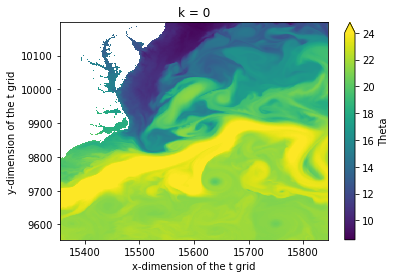

<xarray.Dataset>
Dimensions:  (i: 491, j: 644, k: 52)
Coordinates:
  * i        (i) int64 15355 15356 15357 15358 15359 ... 15842 15843 15844 15845
  * j        (j) int64 9555 9556 9557 9558 9559 ... 10195 10196 10197 10198
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 42 43 44 45 46 47 48 49 50 51
Data variables:
    Theta    (k, j, i) float32 dask.array<chunksize=(10, 100, 100), meta=np.ndarray>
    Salt     (k, j, i) float32 dask.array<chunksize=(10, 100, 100), meta=np.ndarray>
gcs://meom-ige-scratch/roxyboy/region01/LLC4320/apr/TS_28.zarr
<xarray.DataArray 'time' (time: 24)>
array(['2012-04-29T00:00:00.000000000', '2012-04-29T01:00:00.000000000',
       '2012-04-29T02:00:00.000000000', '2012-04-29T03:00:00.000000000',
       '2012-04-29T04:00:00.000000000', '2012-04-29T05:00:00.000000000',
       '2012-04-29T06:00:00.000000000', '2012-04-29T07:00:00.000000000',
       '2012-04-29T08:00:00.000000000', '2012-04-29T09:00:00.000000000',
       '2012-04-29T10:00:00.000000000', '2012

In [6]:
mstart = 5
dstart = 27

istart = 497664
di = 144
for month in list(months.keys())[mstart:]:
    
    dates = pd.date_range(months[month][0],months[month][1],freq='D')
    
    if month == list(months.keys())[mstart]:
        ddstart = dstart
    else:
        ddstart = 0
        
    for dd in range(ddstart,len(dates)):
        
        if month == 'feb':
            iters = np.arange(istart+di*dd*24,
                              istart+di*dd*24+di*24,di)
        elif month == 'mar':
            iters = np.arange(istart+di*dd*24+29*24*di,
                              istart+di*dd*24+di*24+29*24*di,di)
        else:
            iters = np.arange(istart+di*dd*24+(29+31)*24*di,
                              istart+di*dd*24+di*24+(29+31)*24*di,di)
        
        for kk in range(52):
            dsts01 = model.get_dataset(varnames=['Theta','Salt'], k_levels=[kk],
                                       iters=list(iters),
                                       type='latlon'
                                      ).sel(
#                                                   time=slice(str(dates[dd])[:11]+"00:00",
#                                                              str(dates[dd])[:11]+"23:59"),
                                            j=slice(9555,10198),j_g=slice(9555,10198),
                                            i=slice(15355,15845),i_g=slice(15355,15845)
                                           ).reset_coords(drop=True).chunk({'time':-1,'j':200,'i':200})
            if kk == 0:
                print(dsts01.time)
                T = dsts01.Theta.mean('time',skipna=True).compute()
                S = dsts01.Salt.mean('time',skipna=True).compute()
                if dd == dstart:
                    T.isel(k=kk).plot(vmax=24, rasterized=True)
                    plt.show()
            else:
                T = xr.concat([T,dsts01.Theta.mean('time',skipna=True).compute()], 'k')
                S = xr.concat([S,dsts01.Salt.mean('time',skipna=True).compute()], 'k')
                
            dsts01.close()
                
        tmp_path = f'{SCRATCH}/region01/LLC4320/'+str(month)+f'/TS_'+("%02d" % dates[dd].day)+f'.zarr'
        gcs = gcsfs.GCSFileSystem(requester_pays=True)
        store_tmp = gcs.get_mapper(tmp_path)
        dsave = T.chunk({'k':10,'j':100,'i':100}).to_dataset(name='Theta')
        dsave['Salt'] = S.chunk({'k':10,'j':100,'i':100})
        dsave.Theta.encoding = {}
        dsave.Salt.encoding = {}
        if dd == dstart:
            print(dsave)
        dsave.to_zarr(store_tmp, mode='w')
        print(tmp_path)
        dsave.close()
        del T,S
        
#         dd += 1
    
    print(month)

In [10]:
for month in list(months.keys()):
    
    dates = pd.date_range(months[month][0],months[month][1],freq='D')
    
    if month == list(months.keys())[0]:
        dd = 0
    else:
        dd = 0
    while dd < len(dates):
        
        for kk in range(52):
            dsuv01 = model.get_dataset(varnames=['V','U'], k_levels=[kk], 
                                       type='latlon').sel(time=slice(str(dates[dd])[:11]+"00:00",
                                                                     str(dates[dd])[:11]+"23:59"),
                                                          j=slice(9555,10198),j_g=slice(9555,10198),
                                                          i=slice(15355,15845),i_g=slice(15355,15845),
                                                         )
            if kk == 0:
                U = dsuv01.U.mean('time',skipna=True).compute()
                V = dsuv01.V.mean('time',skipna=True).compute()
                if dd == 0:
                    print(W)
                    U.isel(k_l=0).plot(vmax=.1)
                    plt.show()
            else:
                U = xr.concat([U,dsuv01.U.mean('time',skipna=True).compute()], 'k_l')
                V = xr.concat([V,dsuv01.V.mean('time',skipna=True).compute()], 'k_l')
                
        tmp_path = f'{SCRATCH}/region01/'+str(month)+f'/UV_'+("%02d" % dates[dd].day)+f'.zarr'
        gcs = gcsfs.GCSFileSystem(requester_pays=True)
        store_tmp = gcs.get_mapper(tmp_path)
        dsave = U.to_dataset(name='U')
        dsave['V'] = V
        print(dsave)
        dsave.to_zarr(store_tmp, mode='w')
        print(tmp_path)
        
        dd += 1
    
    print(month)

NameError: name 'W' is not defined

In [ ]:

fs_osn = s3fs.S3FileSystem(anon=True, )

url = "s3://Pangeo/pangeo-forge/swot_adac/GIGATL/"
gigatl_datasets = {
    ds: xr.open_zarr(fs_osn.get_mapper(f"{url}{ds}.zarr"), consolidated=True)
    for ds in ["Region01/surf/fma","Region01/surf/aso",
               "Region02/surf/fma","Region02/surf/aso"]
}

gigatl_datasets

In [5]:
gcs = gcsfs.GCSFileSystem(requester_pays=True)
ds = xr.open_zarr(gcs.get_mapper(f"gcs://meom-ige-scratch/roxyboy/region01/sep/W_06.zarr"))
ds

<xarray.Dataset>
Dimensions:  (i: 242, j: 321, k_l: 52)
Coordinates:
    CS       (j, i) float32 dask.array<chunksize=(161, 242), meta=np.ndarray>
    Depth    (j, i) float32 dask.array<chunksize=(161, 242), meta=np.ndarray>
    SN       (j, i) float32 dask.array<chunksize=(161, 242), meta=np.ndarray>
    XC       (j, i) float32 dask.array<chunksize=(161, 242), meta=np.ndarray>
    YC       (j, i) float32 dask.array<chunksize=(161, 242), meta=np.ndarray>
    Zl       (k_l) float32 dask.array<chunksize=(52,), meta=np.ndarray>
    dxF      (j, i) float32 dask.array<chunksize=(161, 242), meta=np.ndarray>
    dyF      (j, i) float32 dask.array<chunksize=(161, 242), meta=np.ndarray>
  * i        (i) int64 7679 7680 7681 7682 7683 ... 7916 7917 7918 7919 7920
  * j        (j) int64 4778 4779 4780 4781 4782 ... 5094 5095 5096 5097 5098
  * k_l      (k_l) int64 0 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50 51
    rA       (j, i) float32 dask.array<chunksize=(161, 242), meta=np.ndarray>
    rLowC    (j, i) float32 dask.array<chunksize=(161, 242), meta=np.ndarray>
    rSurfC   (j, i) float32 dask.array<chunksize=(161, 242), meta=np.ndarray>
Data variables:
    W        (k_l, j, i) float32 dask.array<chunksize=(13, 81, 121), meta=np.ndarray>

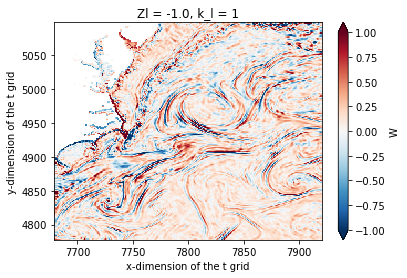

In [24]:
(ds.W.isel(k_l=1)*86400).plot(vmax=1)